In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import SLDS
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.util import random_rotation, find_permutation

In [2]:
# Set the parameters of the HMM
T = 1000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 100     # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_slds = SLDS(N, K, D, emissions="poisson", emission_kwargs=dict(link="softplus"))

# Set rotational dynamics
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
    true_slds.dynamics.bs[k] = 3 * npr.randn(D)
    
# Set an offset to make the counts larger 
# true_slds.emissions.ds += 10

# Sample data
z, x, y = true_slds.sample(T)

# Mask off some data
mask = npr.rand(T, N) < 0.95
y_masked = y * mask

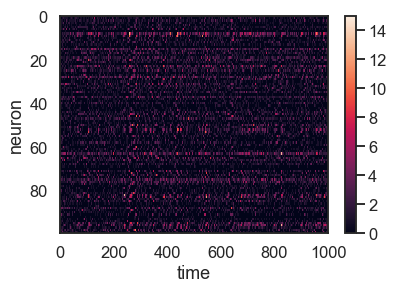

In [4]:
plt.imshow(y.T, aspect="auto", interpolation="none")
plt.xlabel("time")
plt.ylabel("neuron")
plt.colorbar()

In [6]:
print("Fitting SLDS with SVI")
slds = SLDS(N, K, D, emissions="poisson", emission_kwargs=dict(link="softplus"))
slds.initialize(y_masked, masks=mask)

q = SLDSTriDiagVariationalPosterior(slds, y, masks=mask, initial_variance=1)
# q = SLDSMeanFieldVariationalPosterior(slds, y, masks=mask, initial_variance=1)
elbos = slds.fit(q, y_masked, masks=mask, num_iters=5000, print_intvl=100, initialize=False)
slds_x = q.mean[0]


Fitting SLDS with SVI
Initializing with an ARHMM using 25 steps of EM.


Text(0,0.5,'ELBO')

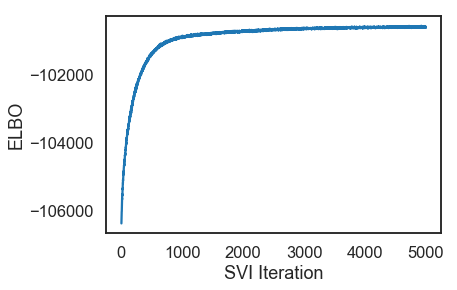

In [7]:
plt.plot(elbos)
plt.xlabel("SVI Iteration")
plt.ylabel("ELBO")

In [8]:
# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(slds_x, y)))
slds_z = slds.most_likely_states(slds_x, y)

In [9]:
# Smooth the observations
slds_y = slds.smooth(slds_x, y)

(0, 1000)

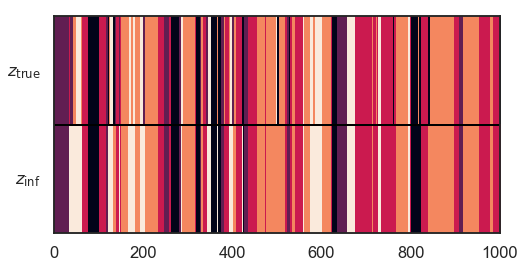

In [10]:
# Plot the true and inferred states
xlim = (0, 1000)

plt.figure(figsize=(8,4))
plt.imshow(np.column_stack((z, slds_z)).T, aspect="auto")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0, 1], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{inf}}$"])
plt.xlim(xlim)

(0, 1000)

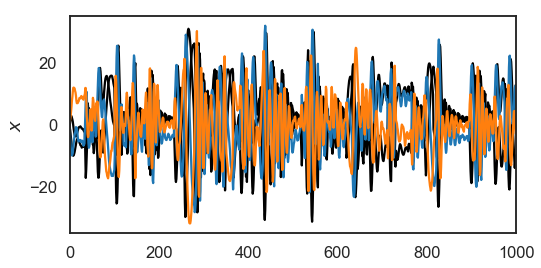

In [11]:
plt.figure(figsize=(8,4))
plt.plot(x, '-k')
plt.plot(slds_x, '-')
plt.ylabel("$x$")
plt.xlim(xlim)

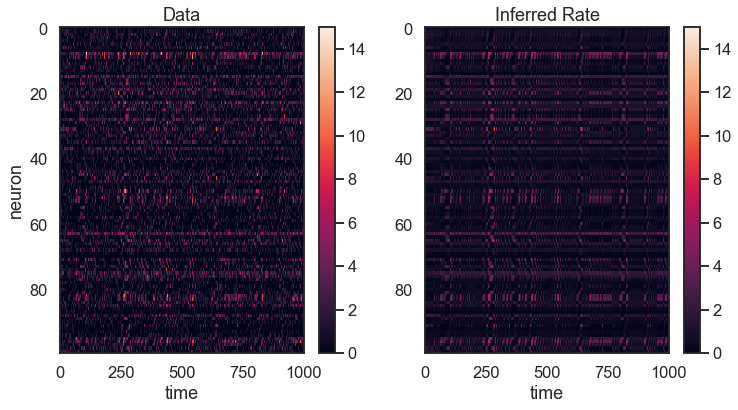

In [21]:
# Plot the smoothed observations
lim = max(y.max(), slds_y.max())
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(y.T, aspect="auto", vmin=0, vmax=lim)
plt.ylabel("neuron")
plt.xlabel("time")
plt.title("Data")
plt.colorbar()

plt.subplot(122)
plt.imshow(slds_y.T, aspect="auto", vmin=0, vmax=lim)
plt.xlabel("time")
plt.title("Inferred Rate")
plt.colorbar()